In [3]:
import pandas as pd
import numpy as np 
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [331]:
#VARIABLE DESCRIPTIONS:
#Variable	          Description
#Loan_ID	                  Unique Loan ID
#Gender	                  Male/ Female
#Married	                  Applicant married (Y/N)
#Dependents	          Number of dependents
#Education	          Applicant Education (Graduate/ Under Graduate)
#Self_Employed	          Self employed (Y/N)
#ApplicantIncome	          Applicant income
#CoapplicantIncome	  Coapplicant income
#LoanAmount	          Loan amount in thousands
#Loan_Amount_Term	  Term of loan in months
#Credit_History	          credit history meets guidelines
#Property_Area	          Urban/ Semi Urban/ Rural
#Loan_Status	          Loan approved (Y/N)

#Read the csv file
df = pd.read_csv("train.csv")
df['LoanAmount'] = df['LoanAmount'] * 1000
df.head(10)
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146412.162162,342.00000,0.842199
std,6109.041673,2926.248369,85587.325236,65.12041,0.364878
min,150.000000,0.000000,9000.000000,12.00000,0.000000
25%,2877.500000,0.000000,100000.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128000.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168000.000000,360.00000,1.000000
max,81000.000000,41667.000000,700000.000000,480.00000,1.000000


In [332]:
df.columns
df['Loan_Status'].value_counts()
df.Loan_Status.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

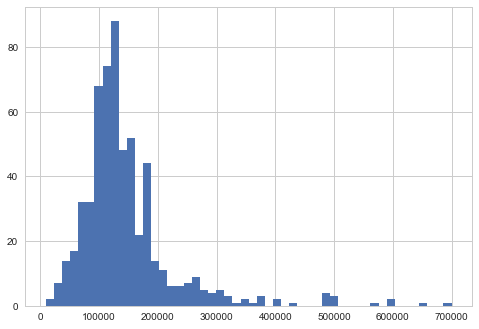

In [333]:
#Histogram and boxplot of loan amount
df['LoanAmount'].hist(bins=50)

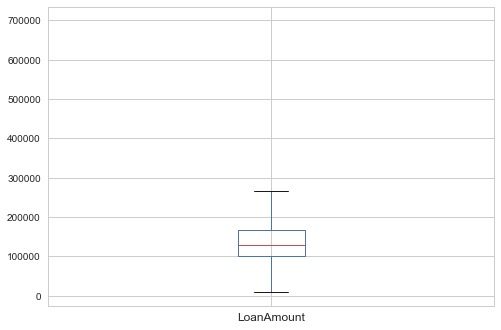

In [334]:
df.boxplot(column='LoanAmount')

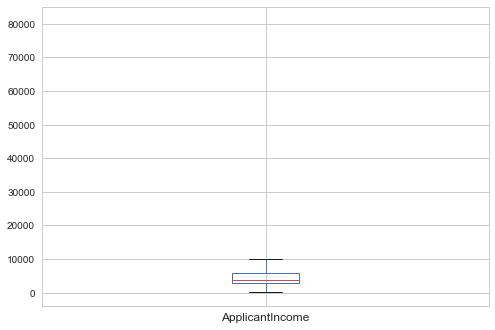

In [335]:
df.boxplot(column='ApplicantIncome')

Applicant income has 14 missing values and outliers and Loan Amount has 22 missing values and outliers. 

Education         
Graduate      0.10     2362.70
              0.25     2998.75
              0.50     4000.00
              1.00    81000.00
Not Graduate  0.10     1995.10
              0.25     2583.00
              0.50     3357.50
              1.00    18165.00
Name: ApplicantIncome, dtype: float64

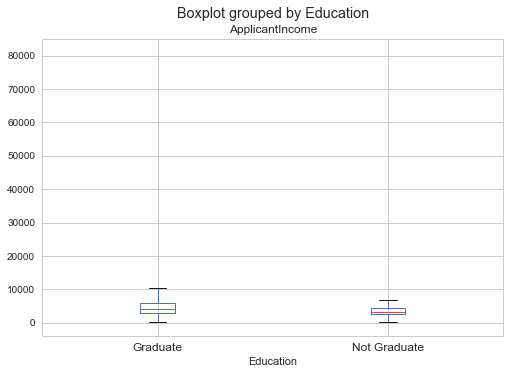

In [336]:
#Application Income by Education
df.boxplot(column='ApplicantIncome', by = 'Education')
#df.groupby(['Education'])['ApplicantIncome'].mean()
df.groupby(['Education'])['ApplicantIncome'].quantile([.1, .25, .5, 1])

On average, Graduates have a higher income (about $2000) relative to Non-Graduates. However, Graduate applicant incomes have outliers that Non-Graduates don't. Both LoanAmount and ApplicantIncome have outliers and missing values that need to be addressed before modeling with this dataset. 

Credit_History  Loan_Status
0.0             N              0.921348
                Y              0.078652
1.0             Y              0.795789
                N              0.204211
Name: Loan_Status, dtype: float64

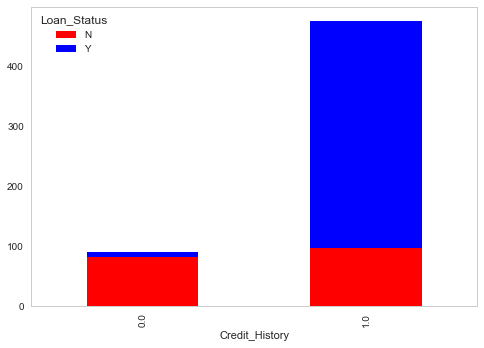

In [337]:
#Plot loan status by credit history 
temp = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)
df.groupby(['Credit_History'])['Loan_Status'].value_counts(normalize=True)

As expected customers with good credit history are more likely to receive a loan relative to those without a good credit history.

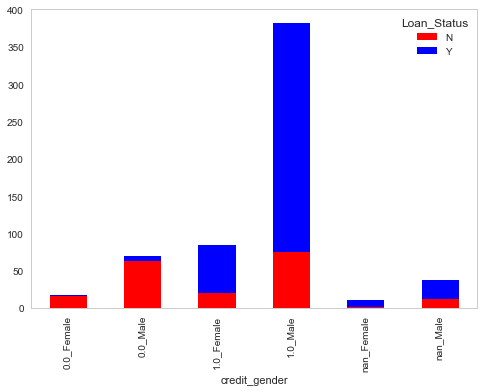

In [338]:
#Credit History & Gender
df['credit_gender'] = pd.Categorical(df['Credit_History'].astype(str)+"_"+ df['Gender'])
temp1 = pd.crosstab(df['credit_gender'], df['Loan_Status'])
temp1.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)

The surprising insight here is on average, it is harder for women with good credit to get a loan than it is for men with good credit. 

In [339]:
#Check missing values in the dataset
df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
credit_gender        13
dtype: int64

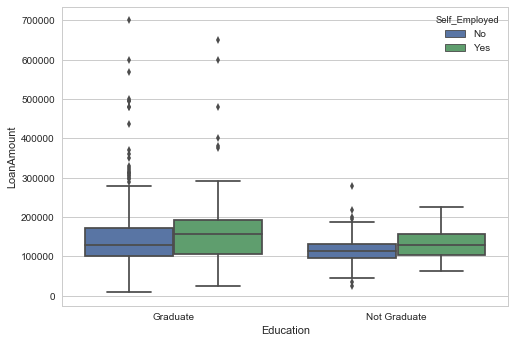

In [340]:
#One of the hypothesis is if people who are self-employed and educated are more likely to get a higher loan amount.
sns.boxplot(x="Education", y="LoanAmount", hue="Self_Employed", data=df)
#The median loan amount varies with education and self-employment status. 

In [341]:
#Frequency count of self-employed status
df.groupby(['Self_Employed']).Loan_Status.value_counts(normalize=True)
#loan_status doesn't vary much by self-employed status - irrespective of the status it is 70%/30% split in favor
#of getting a loan.
#frequency count by marital status
df['Married'].value_counts()
df.groupby(['Married']).Loan_Status.value_counts(normalize=True)
#Married customers are slightly more likely to obtain a loan

Married  Loan_Status
No       Y              0.629108
         N              0.370892
Yes      Y              0.716080
         N              0.283920
Name: Loan_Status, dtype: float64

In [342]:
#Since 86% of the observations are 'No', we can impute the missing values for
df['Self_Employed'].fillna('No', inplace=True)

In [343]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values of loan amount with category specific (self employed, education) loan amounts
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

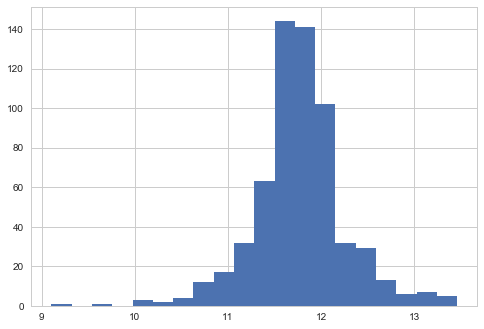

In [344]:
#Since loan amount is right skewed and the outliers are data that should be included in the modeling since some 
#customers may apply for large loan amounts, hence to include them, we compute the log of loan amount 
df['loanamt_log'] = np.log(df['LoanAmount'])
df['loanamt_log'].hist(bins=20)

In [345]:
#Impute Gender, Married, Dependents, loantermamount, credithistory
#impute 13 observations for Gender
df['Gender'].value_counts()
df['Gender'].fillna('Male', inplace=True)

In [346]:
#impute 3 observations
df['Married'].fillna('Yes', inplace=True)
df['Married'].value_counts()

Yes    401
No     213
Name: Married, dtype: int64

In [347]:
#impute 15 observationsn for Dependents. 
df['Dependents'].value_counts()
df['Dependents'].fillna(0, inplace=True)

In [348]:
#Loan Term Amount
df['Loan_Amount_Term'].value_counts()
df['Loan_Amount_Term'].fillna(360.0, inplace=True)

In [349]:
#CreditHistory - this has maximum number of missing values - build a model? 
df['Credit_History'].value_counts()
df['Credit_History'].fillna(1.0, inplace=True)

In [350]:
#Create variables to measure whether customer will pay back the loan
df['totalincome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['totalincome_log'] = np.log(df.totalincome)
df['pay_back'] = df['LoanAmount'] / df['totalincome']
df.groupby('Loan_Status')['totalincome'].mean()
#df.groupby('Loan_Status')['pay_back'].mean()
df.groupby('Loan_Status')['LoanAmount'].mean()
#df.groupby('Loan_Status')['Loan_Amount_Term'].mean()
#Loan amount is slightly lower for customers getting the loan, not much different across the loan_status groups
#for total income and pay_back ratio

Loan_Status
N    149705.729167
Y    143971.563981
Name: LoanAmount, dtype: float64

In [351]:
#urban/semi-urban/rural
df.Property_Area.value_counts()
df.groupby(['Property_Area'])['Loan_Status'].value_counts(normalize=True)
#0: Rural, 1=Semi-Urban, 2=Urban
#Semi-Urban customers are most likely to get a loan followed by Urban and Rural.

Property_Area  Loan_Status
Rural          Y              0.614525
               N              0.385475
Semiurban      Y              0.768240
               N              0.231760
Urban          Y              0.658416
               N              0.341584
Name: Loan_Status, dtype: float64

In [352]:
#Build a predictive model to predict a customer's loan status
#Since sklearn needs all the inputs in the model to be numeric, convert all categorical variables into numeric
#by encoding the categories. 
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status',
           'Credit_History','totalincome_log', 'pay_back', 'loanamt_log', 'Loan_Amount_Term']
le = LabelEncoder()
for i in var_mod:
    #print(df[i])
    df[i] = le.fit_transform(df[i])
    #print(df[i])
df.dtypes

Loan_ID                object
Gender                  int64
Married                 int64
Dependents              int64
Education               int64
Self_Employed           int64
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term        int64
Credit_History          int64
Property_Area           int64
Loan_Status             int64
credit_gender        category
loanamt_log             int64
totalincome           float64
totalincome_log         int64
pay_back                int64
dtype: object

In [353]:
#Define a generic classification function that takes a model as an input and determines the accuracy and 
#cross-validation scores.
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for a classification model and assessing performance:
def classification_model(model, data, predictors, outcome):
    #fit the model:
    model.fit(data[predictors], data[outcome])
    #Make predictions on training set:
    pred = model.predict(data[predictors])
    
    #print accuracy
    accuracy = metrics.accuracy_score(pred, data[outcome])
    print "Accuracy : %s" % "{0:.3%}".format(accuracy)
    
    #perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    cv_accu = []
    for train, test in kf:
        #training data
        train_predictors = (data[predictors].iloc[train,:])
        #dependent variable for training set
        train_target = data[outcome].iloc[train]
        #train the classification model using training predictors and outcome
        model.fit(train_predictors, train_target)
        #compute error from each cross-validation run
        cv_accu.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    print("Cross-Validation Score: %s" % "{0:.3%}".format(np.mean(cv_accu)))

    #fit the model again so it can be refered outside the function:
    model.fit(data[predictors], data[outcome])

In [354]:
#Model loan status using Logistic Regression and only credit class as a predictor since in the exploratory analyses
#above we observed, customers with good credit are 80% likely to get a loan whereas customers with bad credit history
#are 90% likely to not get a loan they applied for
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score: 80.946%


In [355]:
#Add more variables to the predictors list based on observations in the exploratory analyses
#applications with higher education level are likely to get a loan
#Male are more likely to get a loan relative to female
predictor_var = ['Credit_History', 'Education', 'Gender', 'Property_Area']
classification_model(model, df, predictor_var, outcome_var)
#Credit History seems to dominate the model

Accuracy : 80.945%
Cross-Validation Score: 80.946%


In [356]:
#Add loan amount, pay_back ratio and total income
predictor_var = ['Credit_History', 'Education', 'Gender', 'Property_Area', 'loanamt_log', 'pay_back', 'totalincome_log']
classification_model(model, df, predictor_var, outcome_var)

Accuracy : 80.945%
Cross-Validation Score: 80.946%


In [357]:
#Since the accuracy and cross-validation score doesn't seem to improve with Logistic Regression, let us
#explore Decision Tree and Ensemble models
model = DecisionTreeClassifier()
predictor_var = ['Credit_History', 'Education', 'Gender', 'Property_Area', 'loanamt_log', 'pay_back', 'totalincome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score: 69.379%


In [358]:
#Since the accuracy of the model went up to 100%, the model is over-fitting the data. Let's see if we can 
#avoid over-fitting using an ensemble model such as randomforest or xgboost
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Credit_History', 'Education', 'Gender', 'Property_Area', 'loanamt_log', 'pay_back', 'totalincome_log', 
                 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Property_Area']
classification_model(model, df, predictor_var, outcome_var)

Accuracy : 100.000%
Cross-Validation Score: 79.805%


In [359]:
#Since the accuracy is still 100%, let us look at the feature importance matrix to identify the most important features
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print featimp

Credit_History      0.260813
pay_back            0.188997
totalincome_log     0.172319
loanamt_log         0.164890
Dependents          0.049957
Loan_Amount_Term    0.035574
Property_Area       0.026001
Property_Area       0.023307
Married             0.022557
Education           0.021403
Self_Employed       0.018224
Gender              0.015959
dtype: float64


In [360]:
#Let's use the top 5 variables to build the random forest model
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['Credit_History', 'pay_back', 'totalincome_log', 'loanamt_log', 'Dependents']
classification_model(model, df, predictor_var, outcome_var)

Accuracy : 82.899%
Cross-Validation Score: 80.782%


In [361]:
#The above is a good model to use since even though it has lower accuracy that previous models, the cross-validation 
#score is improving which means that the model is generalizing well. Use this model to score the test data
df_test = pd.read_csv("test.csv")
df_test['LoanAmount'] = df['LoanAmount'] * 1000
#df_test.head(10)
#df_test.describe()


In [362]:
#Check missing values in the dataset
df_test.apply(lambda x: sum(x.isnull()), axis=0)
#To impute missing values, use average or largest percentage value

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [363]:
df_test.Gender.value_counts(normalize=True)
df_test.Gender.fillna('Male', inplace=True)

In [364]:
df_test.Dependents.value_counts(normalize=True)
df_test.Dependents.fillna(0, inplace=True)

In [365]:
df_test.Self_Employed.value_counts(normalize=True)
df_test.Self_Employed.fillna('No', inplace=True)

In [366]:
df_test.LoanAmount.describe()
df_test.LoanAmount.fillna(df_test.LoanAmount.mean(), inplace=True)

In [367]:
df_test.Loan_Amount_Term.value_counts()
df_test.Loan_Amount_Term.fillna(360.0, inplace=True)

In [368]:
df_test.Credit_History.value_counts()
df_test.Credit_History.fillna(1.0, inplace=True)

In [369]:
predictor_var = ['Credit_History', 'pay_back', 'totalincome_log', 'loanamt_log', 'Dependents']
df_test['totalincome'] = df_test.ApplicantIncome + df_test.CoapplicantIncome
df_test['pay_back'] = df_test['LoanAmount'] / df_test['totalincome']
df_test['totalincome_log'] = np.log(df_test.totalincome)
df_test['loanamt_log'] = np.log(df_test.LoanAmount)


In [370]:
#Convert the variables to numeric
var_mod = predictor_var
le = LabelEncoder()
for i in var_mod:
    df_test[i] = le.fit_transform(df_test[i])
#df.dtypes

In [371]:
df_test['Loan_Status_Pred'] = model.predict(df_test[predictor_var])
df_test['Loan_Status'] = np.where(df_test['Loan_Status_Pred']==1, 'Y', 'N')

In [372]:
df_test.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,totalincome,pay_back,totalincome_log,loanamt_log,Loan_Status_Pred,Loan_Status
0,LP001015,Male,Yes,1,Graduate,No,5720,0,130000000.0,360.0,1,Urban,5720,171,207,70,1,Y
1,LP001022,Male,Yes,2,Graduate,No,3076,1500,128000000.0,360.0,1,Urban,4576,220,124,68,1,Y
2,LP001031,Male,Yes,3,Graduate,No,5000,1800,66000000.0,360.0,1,Urban,6800,33,251,17,1,Y
3,LP001035,Male,Yes,3,Graduate,No,2340,2546,120000000.0,360.0,1,Urban,4886,188,148,60,1,Y
4,LP001051,Male,No,1,Not Graduate,No,3276,0,141000000.0,360.0,1,Urban,3276,311,36,81,1,Y
5,LP001054,Male,Yes,1,Not Graduate,Yes,2165,3422,267000000.0,360.0,1,Urban,5587,319,198,129,1,Y
6,LP001055,Female,No,2,Not Graduate,No,2226,0,95000000.0,360.0,1,Semiurban,2226,310,3,38,0,N
7,LP001056,Male,Yes,3,Not Graduate,No,3881,0,158000000.0,360.0,0,Rural,3881,303,70,90,0,N
8,LP001059,Male,Yes,3,Graduate,No,13633,0,168000000.0,240.0,1,Urban,13633,57,333,97,1,Y
9,LP001067,Male,No,1,Not Graduate,No,2400,2400,349000000.0,360.0,1,Semiurban,4800,350,143,142,1,Y


In [373]:
df_test.to_csv("submission_1.csv")